# Designing Quantum Error-Correcting Codes


In [1]:
%matplotlib inline

/home/angelo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [1]:
import numpy as np
import stim
import model

In [2]:
surface_code = model.StabilizerModel("surface", scale=(5,5), rounds=1)
# surface_code.print()

[-3, -8, -9]


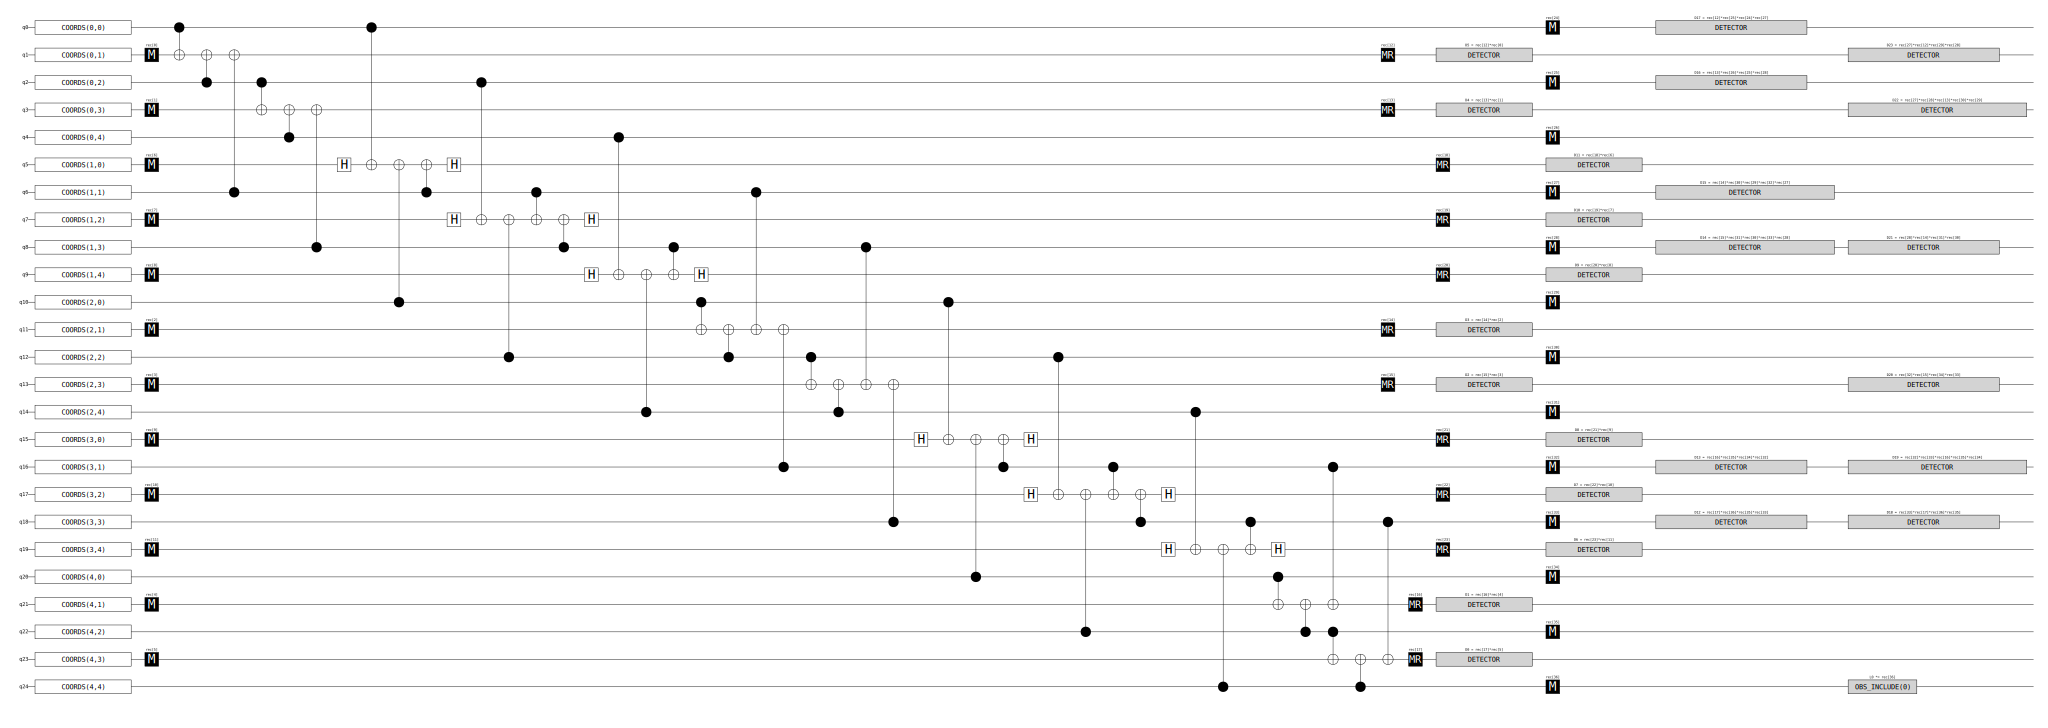

In [4]:
surface_code.circuit.without_noise().diagram("timeline")

In [ ]:
# surface_code_tasks = [
#     sinter.Task(
#         circuit = stim.Circuit.generated(
#             "surface_code:rotated_memory_z",
#             rounds=distance * 3,
#             distance=distance,
#             after_clifford_depolarization=noise,
#             after_reset_flip_probability=noise,
#             before_measure_flip_probability=noise,
#             before_round_data_depolarization=noise,
#         ),
#         json_metadata={'distance': d, 'rounds': d * 3, 'p': noise},
#     )
#     for d in [3, 5, 7]
#     for noise in [0.008, 0.009, 0.01, 0.011, 0.012]
# ]